In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
import gmaps
import statsmodels.api as sm

import pytz

import psycopg2

from sklearn.linear_model import Ridge

import spacy

import swifter

import requests

import vincent

from io import StringIO

import altair as alt
from vega_datasets import data

In [4]:
# Plot settings
%pylab inline

figsize(15, 9)

import matplotlib.style as style

style.use('childsafeai')

alt.renderers.enable('default')

Populating the interactive namespace from numpy and matplotlib


RendererRegistry.enable('default')

In [5]:
from local_settings import GOOGLE_API_KEY

gmaps.configure(GOOGLE_API_KEY)

# Supply Chain Risk

## Processing

In [6]:
# Grab 30,000 warehousese from Reonomy

warehouses = requests.get("https://www.reonomy.com/properties/geosearch?nw_lat=56.808103545962894&nw_lon=-175&se_lat=17&se_lon=-71.59679843434361&land_use=warehouse&size=30000").json()

In [7]:
processed_warehouses = []

for warehouse in warehouses:
    property_id = warehouse['property_id']
    lat = warehouse['location']['lat']
    long = warehouse['location']['lon']
    
    processed_warehouses.append({'property_id': property_id,
                                 'latitude': lat,
                                 'longitude': long})

In [8]:
warehouses = pd.DataFrame(processed_warehouses)
warehouses

property_id            latitude  \
0      cd899813-c893-5705-9f75-f039393ce07c  38.981038396896146   
1      caaca9ce-dd89-55df-bd92-004736a313c5   38.35915186162671   
2      113c5b6d-454c-52ea-be88-ec5f0a455fd9  41.325688832634484   
3      d29faeaf-03b6-52c3-a8c3-4cfc943ab763    36.4685322287344   
4      df75c3b3-c63f-5011-affe-49e0a493b81e   33.73463937870912   
...                                     ...                 ...   
29995  8686f0ad-e348-516c-933e-8ba1a72f4607   28.95084027376255   
29996  eb5a0967-8dd0-569c-a11b-c3d18a7a390a   42.80253235794803   
29997  4f29e297-c140-56f9-b834-787b3b0bdb60   37.24287847879876   
29998  45f55231-b883-5c66-95e9-708c3a908a64   33.97152774095353   
29999  d9f1b1ec-21fb-5ab3-8ac2-015aef253df8   32.64476013183594   

                longitude  
0      -84.60000458303602  
1      -75.59632371987615  
2      -84.03369227500116  
3        -97.947820713519  
4       -118.034000662748  
...                   ...  
29995  -95.97029421990058  
29996   -91.1147838265635  
29997  -77.36472638205558  
29998   -86.0099510394587  
29999  -92.50180053710938  

[30000 rows x 3 columns]

In [9]:
def get_fips_code_for_warehouse(row):
    results = requests.get('https://geo.fcc.gov/api/census/block/find?format=json&latitude={0}&longitude={1}'.format(row['latitude'],
                                                                                                                     row['longitude'])).json()
    
    row['county_fips_code'] = results['County']['FIPS']
    row['county_name'] = results['County']['name']
    row['state_fips_code'] = results['State']['FIPS']
    row['state_code'] = results['State']['code']
    row['state'] = results['State']['name']
    
    return row

In [10]:
'''
warehouses['county_fips_code'] = None
warehouses['county_name'] = None
warehouses['state_fips_code'] = None
warehouses['state_code'] = None
warehouses['state'] = None

warehouses = warehouses.swifter.apply(get_fips_code_for_warehouse, axis=1)
'''

"\nwarehouses['county_fips_code'] = None\nwarehouses['county_name'] = None\nwarehouses['state_fips_code'] = None\nwarehouses['state_code'] = None\nwarehouses['state'] = None\n\nwarehouses = warehouses.swifter.apply(get_fips_code_for_warehouse, axis=1)\n"

In [11]:
#warehouses.to_excel('data/warehouses_with_fips_codes.xlsx')

In [12]:
warehouses = pd.read_excel('data/warehouses_with_fips_codes.xlsx')

In [13]:
len(warehouses)

30000

In [14]:
travel_change_by_county_csv = requests.get("https://static01.nyt.com/newsgraphics/2020/03/27/coronavirus-behavior-int/237a8c3b632d9f46dc03eb9c749ac7f2665ac165/pct_change_04_01.csv")

In [15]:
travel_change_by_county = pd.read_csv(StringIO(travel_change_by_county_csv.content.decode('utf-8')))

In [16]:
travel_change_by_county.dtypes

county_fips_code      int64
in_lockdown            bool
pct_change          float64
pop                   int64
label                object
dtype: object

In [17]:
geocodes = pd.read_excel('data/fips_to_state.xlsx')

In [18]:
geocodes

FIPS        Name State
0      1001     Autauga    AL
1      1003     Baldwin    AL
2      1005     Barbour    AL
3      1007        Bibb    AL
4      1009      Blount    AL
...     ...         ...   ...
3227  72151     Yabucoa    PR
3228  72153       Yauco    PR
3229  78010   St. Croix    VI
3230  78020    St. John    VI
3231  78030  St. Thomas    VI

[3232 rows x 3 columns]

In [19]:
travel_change_by_county = pd.merge(travel_change_by_county,
                                   geocodes[['FIPS', 'Name', 'State']],
                                   left_on='county_fips_code', 
                                   right_on='FIPS',
                                   how='left')

In [20]:
travel_change_by_county

county_fips_code  in_lockdown  pct_change     pop           label  \
0                 1001        False      -0.616   55869     Autauga, AL   
1                 1003        False      -0.544  223234     Baldwin, AL   
2                 1005        False      -0.510   24686     Barbour, AL   
3                 1007        False      -0.615   22394        Bibb, AL   
4                 1009        False      -0.574   57826      Blount, AL   
...                ...          ...         ...     ...             ...   
3137             56037        False      -0.509   42343  Sweetwater, WY   
3138             56039        False      -0.738   23464       Teton, WY   
3139             56041        False      -0.434   20226       Uinta, WY   
3140             56043        False      -0.454    7805    Washakie, WY   
3141             56045        False      -0.491    6927      Weston, WY   

         FIPS        Name State  
0      1001.0     Autauga    AL  
1      1003.0     Baldwin    AL  
2      1005.0     Barbour    AL  
3      1007.0        Bibb    AL  
4      1009.0      Blount    AL  
...       ...         ...   ...  
3137  56037.0  Sweetwater    WY  
3138  56039.0       Teton    WY  
3139  56041.0       Uinta    WY  
3140  56043.0    Washakie    WY  
3141  56045.0      Weston    WY  

[3142 rows x 8 columns]

In [21]:
%store -r tests_df
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                   float64
totalTestResults                        float64
posNeg                                  float64
fips                                     object
deathIncrease                           

In [22]:
travel_change_by_county = pd.merge(left=travel_change_by_county,
                                   right=tests_df.groupby('state')[['positive', 'negative', 'pending', 'total', 'hospitalizedCumulative', 'inIcuCumulative', 'onVentilatorCumulative', 'death']].max().reset_index(),
                                   left_on='State',
                                   right_on='state',
                                   how="left")

In [23]:
len(travel_change_by_county)

3142

In [24]:
travel_change_by_county['Quartile of Travel'] = None

def classify_quartile_of_travel(row):
    quartiles = travel_change_by_county['pct_change'].quantile(q=[0.25, 0.5, 0.75]).values
    
    i = 1
    
    for quartile in quartiles:
        if row['pct_change'] >= quartile:
            i = i + 1
    
    row['Quartile of Travel'] = quartile_mapping[i]
    
    return row

travel_change_by_county = travel_change_by_county.swifter.apply(classify_quartile_of_travel, axis=1)

NameError: ("name 'quartile_mapping' is not defined", 'occurred at index 0')

In [ ]:
len(warehouses)

In [ ]:
us_state_abbreviations = pd.read_csv('data/us_state_abbreviations.csv')
us_state_abbreviations = us_state_abbreviations.groupby('Abbreviation')['Full Name'].max().to_dict()
us_state_abbreviations[np.nan] = 'Unknown'
us_state_abbreviations['DC'] = 'District of Columbia'

travel_change_by_county['State'] = travel_change_by_county['State'].map(lambda x: us_state_abbreviations[x] if not x == np.nan else x)
travel_change_by_county

In [ ]:
tests_df['State'] = tests_df['state'].map(lambda x: us_state_abbreviations[x] if x in us_state_abbreviations else x)

In [ ]:
travel_change_by_county[travel_change_by_county['FIPS'].isna()]

In [ ]:
# Fix some state names that are missing FIPS.
travel_change_by_county.at[76, 'State'] = 'Alaska'
travel_change_by_county.at[81, 'State'] = 'Alaska'
travel_change_by_county.at[87, 'State'] = 'Alaska'
travel_change_by_county.at[88, 'State'] = 'Alaska'
travel_change_by_county.at[90, 'State'] = 'Alaska'
travel_change_by_county.at[93, 'State'] = 'Alaska'
travel_change_by_county.at[251, 'State'] = 'Colorado'
travel_change_by_county.at[548, 'State'] = 'Hawaii'
travel_change_by_county.at[2412, 'State'] = 'South Dakota'

In [ ]:
imhe_projections = pd.read_csv('data/ihme_projections_2020-04-07.csv')

In [ ]:
imhe_projections['date'] = pd.to_datetime(imhe_projections['date'])

In [ ]:
imhe_projections[imhe_projections['location_name'] == 'Wyoming'].groupby('date')['allbed_mean'].sum().idxmax()

In [ ]:
covid_stages = ['Hospitalization',
                'Ventilation',
                'Death',
                'Hospital Bed Overcapacity',
                'ICU Overcapacity']

stage_to_imhe_mapping = {'Hospitalization': 'admis_mean',
                         'Ventilation': 'InvVen_mean',
                         'Death': 'deaths_mean',
                         'Hospital Bed Overcapacity': 'bedover_mean',
                         'ICU Overcapacity': 'icuover_mean'}

In [ ]:
for stage in covid_stages:
    travel_change_by_county["Peak {0}".format(stage)] = None
    travel_change_by_county["Peak {0} Date".format(stage)] = None


def find_imhe_peaks(row):
    for stage in covid_stages:
        row["Peak {0}".format(stage)] = imhe_projections[imhe_projections['location_name'] == row['State']].groupby('date')[stage_to_imhe_mapping[stage]].sum().max()
        row["Peak {0} Date".format(stage)] = imhe_projections[imhe_projections['location_name'] == row['State']].groupby('date')[stage_to_imhe_mapping[stage]].sum().idxmax()
        
    return row

travel_change_by_county = travel_change_by_county.swifter.apply(find_imhe_peaks, axis=1)

In [ ]:
warehouses_with_social_distancing = pd.merge(left=warehouses, right=travel_change_by_county, on='county_fips_code', how='left', suffixes=["_reonomy", "_nyt"])
del(warehouses_with_social_distancing['Unnamed: 0'])
warehouses_with_social_distancing

In [ ]:
warehouses_with_social_distancing['State'] = warehouses_with_social_distancing['state_reonomy']

In [ ]:
travel_change_by_county['Warehouses'] = travel_change_by_county['county_fips_code'].map(lambda x: warehouses_with_social_distancing[warehouses_with_social_distancing['county_fips_code'] == x]['property_id'].count().sum())

In [ ]:
warehouses_with_social_distancing['Total COVID-19 Tests'] = warehouses_with_social_distancing['State'].map(lambda x: tests_df[tests_df['State'] == x]['total'].max())

## Analysis

In [ ]:
data.us_10m.url

In [ ]:
alt.data_transformers.disable_max_rows()

In [ ]:
counties

In [ ]:
counties = alt.topo_feature(data.us_10m.url, 'counties')
source = "https://static01.nyt.com/newsgraphics/2020/03/27/coronavirus-behavior-int/237a8c3b632d9f46dc03eb9c749ac7f2665ac165/pct_change_04_01.csv"

background = alt.Chart(counties).mark_geoshape().encode(
    color=alt.Color('pct_change',
              type="quantitative",
              scale=alt.Scale(scheme="lightgreyred",
                              reverse=False),
              title="Percentage Change in Travel"),
    tooltip=['label:N',
             'pct_change:Q']
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(travel_change_by_county[-(travel_change_by_county['pct_change'] >= 0)], 'county_fips_code', ['pct_change', 'label'])
).project(
    type='albersUsa'
).properties(
    width=1280,
    height=720,
    title="Choropleth of US Counties by Percentage Change in Travel In March With Location of US Warehouses (Sources: The New York Times and Reonomy)"
)

background.configure_title(
    color="#232323",
    fontSize=12
)

points = alt.Chart(warehouses).encode(
    latitude='latitude:Q',
    longitude='longitude:Q',
    color=alt.value('#232323')
).mark_point(size=2, opacity=0.5)

background + points

In [25]:
counties = alt.topo_feature(data.us_10m.url, 'counties')
source = "https://static01.nyt.com/newsgraphics/2020/03/27/coronavirus-behavior-int/237a8c3b632d9f46dc03eb9c749ac7f2665ac165/pct_change_04_01.csv"

background = alt.Chart(counties).mark_geoshape().encode(
    color=alt.Color('pct_change',
              type="quantitative",
              scale=alt.Scale(scheme="lightgreyred",
                              reverse=False),
              title="Percentage Change in Travel"),
    tooltip=['label:N',
             'pct_change:Q']
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(travel_change_by_county[-(travel_change_by_county['pct_change'] >= 0)], 'county_fips_code', ['pct_change', 'label'])
).project(
    type='albersUsa'
).properties(
    width=1280,
    height=720,
    title="Choropleth of US Counties by Percentage Change in Travel In March With Location of US Warehouses (Sources: The New York Times and Reonomy)"
)

background.configure_title(
    color="#232323",
    fontSize=12
)

background

alt.Chart(...)

In [ ]:
counties = alt.topo_feature(data.us_10m.url, 'counties')
source = "https://static01.nyt.com/newsgraphics/2020/03/27/coronavirus-behavior-int/237a8c3b632d9f46dc03eb9c749ac7f2665ac165/pct_change_04_01.csv"

background = alt.Chart(counties).mark_geoshape().encode(
    color=alt.Color('pct_change',
              type="quantitative",
              scale=alt.Scale(scheme="lightgreyred",
                              reverse=False),
              title="Percentage Change in Travel"),
    tooltip=['label:N',
             'pct_change:Q']
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(travel_change_by_county[-(travel_change_by_county['pct_change'] >= 0)], 'county_fips_code', ['pct_change', 'label'])
).project(
    type='albersUsa'
).properties(
    width=1280,
    height=720
)

points = alt.Chart(warehouses).encode(
    latitude='latitude:Q',
    longitude='longitude:Q',
    color=alt.value('#232323')
).mark_point(size=2, opacity=0.5)

background + points

Text(0.5, 1.0, 'Distribution of Change of Travel Percentage For US Counties (Source: The New York Times)')

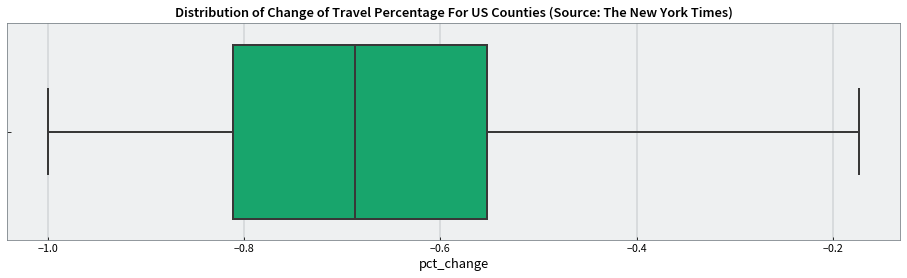

In [569]:
figsize(16, 4)
ax = sns.boxplot(x=travel_change_by_county['pct_change'], showfliers=False)
ax.set_title("Distribution of Change of Travel Percentage For US Counties (Source: The New York Times)")

In [918]:
tests_df

date state  positive  negative  pending  hospitalizedCurrently  \
0     20200407    AK     213.0    6700.0      NaN                    NaN   
1     20200407    AL    2119.0   12797.0      NaN                    NaN   
2     20200407    AR     946.0   12692.0      NaN                   74.0   
3     20200407    AS       0.0      20.0     11.0                    NaN   
4     20200407    AZ    2575.0   30800.0      NaN                    NaN   
...        ...   ...       ...       ...      ...                    ...   
1816  20200304    OR       3.0      29.0     18.0                    NaN   
1817  20200304    SC       0.0       5.0      0.0                    NaN   
1818  20200304    TX       1.0       NaN      NaN                    NaN   
1819  20200304    WA      39.0       NaN      NaN                    NaN   
1820  20200304    WI       1.0      19.0      6.0                    NaN   

      hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
0                       23.0             NaN              NaN   
1                      271.0             NaN              NaN   
2                      130.0             NaN             43.0   
3                        NaN             NaN              NaN   
4                        NaN             NaN              NaN   
...                      ...             ...              ...   
1816                     NaN             NaN              NaN   
1817                     NaN             NaN              NaN   
1818                     NaN             NaN              NaN   
1819                     NaN             NaN              NaN   
1820                     NaN             NaN              NaN   

      onVentilatorCurrently  ...  totalTestResults  posNeg fips deathIncrease  \
0                       NaN  ...              6913    6913    2           0.0   
1                       NaN  ...             14916   14916    1           6.0   
2                      26.0  ...             13638   13638    5           0.0   
3                       NaN  ...                20      20   60           0.0   
4                       NaN  ...             33375   33375    4           8.0   
...                     ...  ...               ...     ...  ...           ...   
1816                    NaN  ...                32      32   41           NaN   
1817                    NaN  ...                 5       5   45           NaN   
1818                    NaN  ...                 1       1   48           NaN   
1819                    NaN  ...                39      39   53           NaN   
1820                    NaN  ...                20      20   55           NaN   

      hospitalizedIncrease  negativeIncrease  positiveIncrease  \
0                      0.0               8.0              22.0   
1                     31.0               0.0             151.0   
2                     -7.0             722.0              71.0   
3                      0.0               0.0               0.0   
4                      0.0             722.0             119.0   
...                    ...               ...               ...   
1816                   NaN               NaN               NaN   
1817                   NaN               NaN               NaN   
1818                   NaN               NaN               NaN   
1819                   NaN               NaN               NaN   
1820                   NaN               NaN               NaN   

      totalTestResultsIncrease       Date  completed  
0                         30.0 2020-04-07     6913.0  
1                        151.0 2020-04-07    14916.0  
2                        793.0 2020-04-07    13638.0  
3                          0.0 2020-04-07       20.0  
4                        841.0 2020-04-07    33375.0  
...                        ...        ...        ...  
1816                       NaN 2020-03-04       32.0  
1817                       NaN 2020-03-04        5.0  
1818                       NaN 2020-03-04        NaN  


In [951]:
def normalize_by_group(df, by):
    groups = df.groupby(by)
    # computes group-wise mean/std,
    # then auto broadcasts to size of group chunk
    mean = groups.transform(np.mean)
    std = groups.transform(np.std)
    return (df[mean.columns] - mean) / std

In [957]:
normalized = (f-f.min()) / (f.max() - f.min())
normalized

Tests  Warehouses
State                                     
Alabama               0.032468    0.177573
Alaska                0.008653    0.000953
Arizona               0.087397    0.354511
Arkansas              0.028665    0.075604
California            0.420541    0.842757
Colorado              0.068055    0.307179
Connecticut           0.074485    0.020330
District of Columbia  0.011361    0.012389
Florida               0.403401    0.748094
Georgia               0.088403    0.385959
Hawaii                0.028379    0.011753
Idaho                 0.021547    0.027319
Illinois              0.192609    0.045426
Indiana               0.073676    0.203621
Iowa                  0.025927    0.341804
Kansas                0.016393    0.357052
Kentucky              0.047463    0.093075
Louisiana             0.210235    0.148348
Maryland              0.082195    0.166455
Massachusetts         0.230139    0.057497
Michigan              0.137856    0.136595
Minnesota             0.075152    0.129288
Mississippi           0.049224    0.058132
Missouri              0.083213    0.267154
Montana               0.008868    0.003177
Nebraska              0.009680    0.095616
Nevada                0.043547    0.090534
New Hampshire         0.014218    0.001588
New Jersey            0.270698    0.013342
New Mexico            0.053027    0.083545
New York              1.000000    0.216010
North Carolina        0.110331    0.522554
North Dakota          0.011004    0.041931
Ohio                  0.139362    0.613088
Oklahoma              0.027638    0.269695
Oregon                0.052956    0.147395
Pennsylvania          0.259700    0.387230
South Carolina        0.058547    0.190280
South Dakota          0.006740    0.004447
Tennessee             0.145421    0.192821
Texas                 0.251877    1.000000
Utah                  0.091182    0.067980
Vermont               0.009296    0.000000
Virginia              0.073322    0.138501
Washington            0.261179    0.231576
West Virginia         0.023966    0.099746
Wisconsin             0.080597    0.045426
Wyoming               0.000000    0.074015

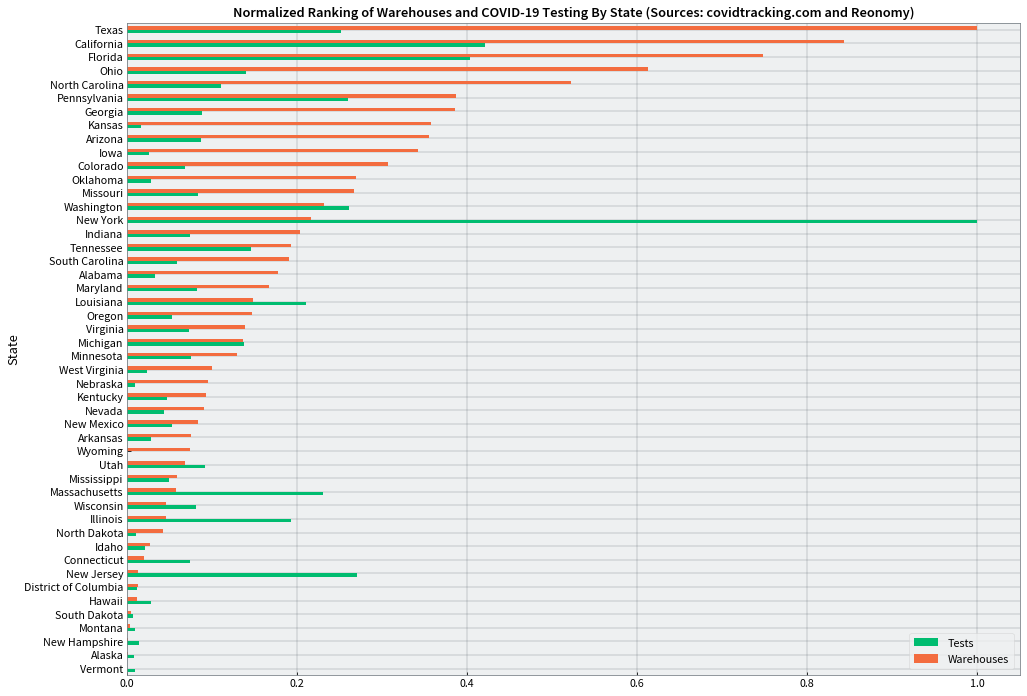

In [962]:

figsize(16, 12)
normalized.sort_values(by='Warehouses').plot(kind='barh',
                                             title="Normalized Ranking of Warehouses and COVID-19 Testing By State (Sources: covidtracking.com and Reonomy)")

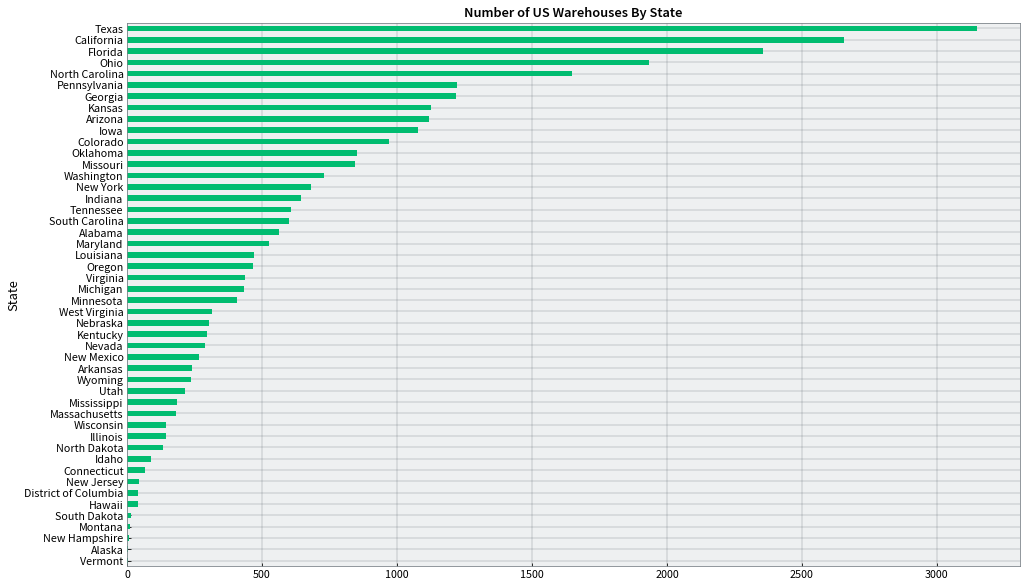

In [930]:
figsize(16, 10)
source = warehouses_with_social_distancing.groupby('State')['property_id'].count().sort_values()
ax = source.plot(kind='barh',
                 title="Number of US Warehouses By State")

In [986]:
figsize(16, 9)
alt.Chart(travel_change_by_county[-(travel_change_by_county['pct_change'] > 0)]).mark_circle().encode(
    alt.X('pct_change'),
    alt.Y('Warehouses'),
    size='pop',
    tooltip=['label:N',
             'Warehouses:Q']
).properties(
    width=1280,
    height=720
)

alt.Chart(...)

In [988]:
travel_change_by_county[travel_change_by_county['label'] == 'Harris, TX']

county_fips_code  in_lockdown  pct_change      pop       label     FIPS  \
2623             48201         True      -0.754  4713325  Harris, TX  48201.0   

        Name  State state  positive  ...  Peak Hospitalization Date  \
2623  Harris  Texas    TX    8262.0  ...                 2020-04-19   

      Peak Ventilation  Peak Ventilation Date  Peak Death  Peak Death Date  \
2623        584.656223             2020-04-23      66.488       2020-04-24   

      Peak Hospital Bed Overcapacity  Peak Hospital Bed Overcapacity Date  \
2623                             0.0                           2020-01-03   

     Peak ICU Overcapacity  Peak ICU Overcapacity Date  \
2623                   0.0                  2020-01-03   

      State Total COVID-19 Tests  
2623                     88649.0  

[1 rows x 30 columns]

In [989]:
travel_change_by_county[travel_change_by_county['State'] == 'Texas']['pct_change'].mean()

-0.672724409448819

In [599]:
figsize(16, 9)
alt.Chart(travel_change_by_county[-(travel_change_by_county['pct_change'] > 0)]).mark_circle().encode(
    alt.X('pct_change'),
    alt.Y('total'),
    size='Warehouses',
    tooltip=['label:N',
             'Warehouses:Q',
             'pct_change:Q']
).properties(
    width=900,
    height=600
)

alt.Chart(...)

In [914]:
warehouses_with_social_distancing.groupby('in_lockdown')['property_id'].count()

in_lockdown
False    15051
True     14949
Name: property_id, dtype: int64

Text(0, 0.5, '')

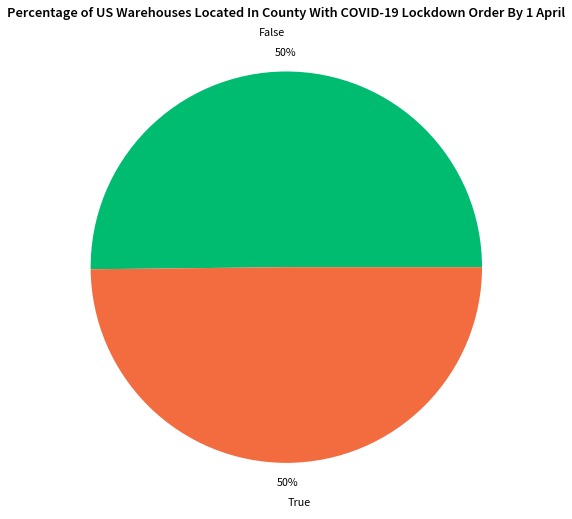

In [913]:
ax = warehouses_with_social_distancing.groupby('in_lockdown')['property_id'].count().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2,
                                                                                     title="Percentage of US Warehouses Located In County With COVID-19 Lockdown Order By 1 April")
ax.set_ylabel("")

In [915]:
warehouses_with_social_distancing.groupby('in_lockdown')['pct_change'].mean()

in_lockdown
False   -0.636219
True    -0.821790
Name: pct_change, dtype: float64

Text(0.5, 0, 'Percentage Change in Travel')

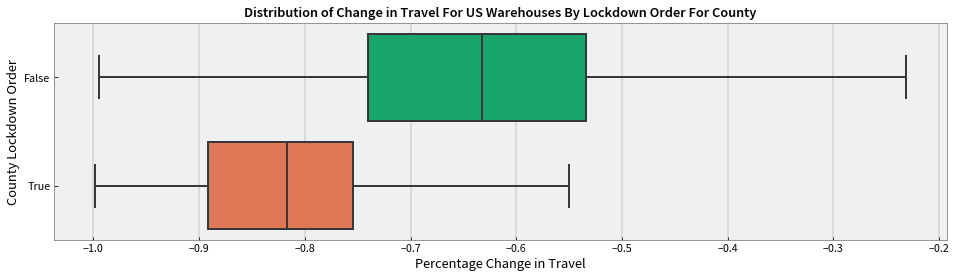

In [916]:
figsize(16, 4)
ax = sns.boxplot(y='in_lockdown', x='pct_change', data=warehouses_with_social_distancing, orient='h', showfliers=False)
ax.set_title("Distribution of Change in Travel For US Warehouses By Lockdown Order For County")
ax.set_ylabel("County Lockdown Order")
ax.set_xlabel("Percentage Change in Travel")

In [616]:
travel_change_by_county['pct_change'].quantile(q=[0.25, 0.5, 0.75])

0.25   -0.81100
0.50   -0.68700
0.75   -0.55225
Name: pct_change, dtype: float64

In [617]:
quartile_mapping = {1: ">81%",
                    2: "68-81%",
                    3: "55-68%",
                    4: "<55%"}

In [618]:
travel_change_by_county['Quartile of Travel'] = None

def classify_quartile_of_travel(row):
    quartiles = travel_change_by_county['pct_change'].quantile(q=[0.25, 0.5, 0.75]).values
    
    i = 1
    
    for quartile in quartiles:
        if row['pct_change'] >= quartile:
            i = i + 1
    
    row['Quartile of Travel'] = quartile_mapping[i]
    
    return row

travel_change_by_county = travel_change_by_county.swifter.apply(classify_quartile_of_travel, axis=1)

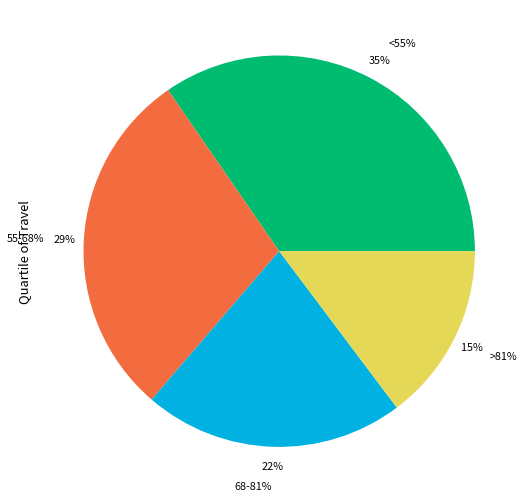

In [619]:
travel_change_by_county[travel_change_by_county['in_lockdown'] == False]['Quartile of Travel'].value_counts().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)

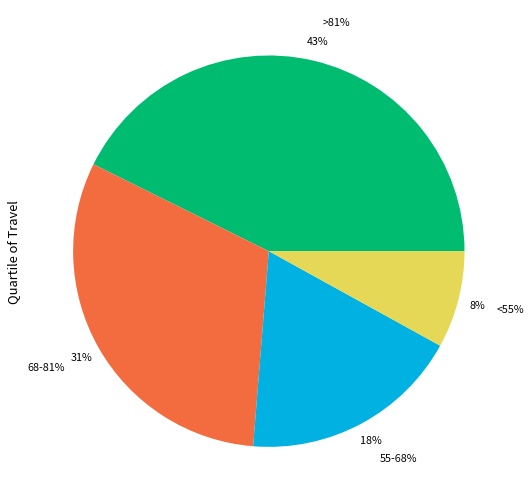

In [647]:
travel_change_by_county[travel_change_by_county['in_lockdown'] == True]['Quartile of Travel'].value_counts().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)

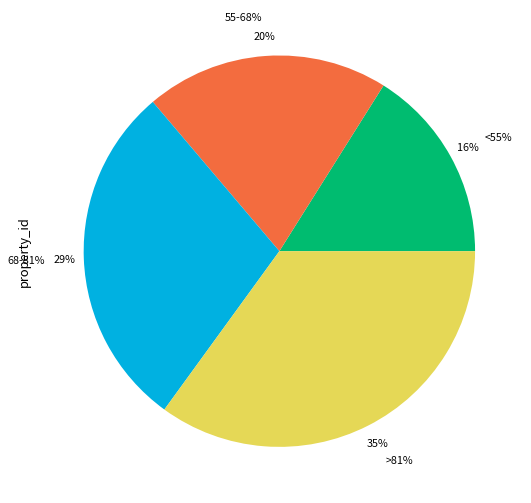

In [715]:
warehouses_with_social_distancing.groupby('Quartile of Travel')['property_id'].count().sort_values().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)

In [964]:
f = travel_change_by_county.groupby('Peak Hospitalization Date')['Warehouses'].sum().resample('W').sum().to_frame()
f['Peak Hospitalization'] = f['Warehouses']
del(f['Warehouses'])
f['Peak Death'] = travel_change_by_county.groupby('Peak Death Date')['Warehouses'].sum().resample('W').sum()
f.index = f.index.rename('Date')
f = f.reset_index()

In [965]:
f = f.melt(id_vars=['Date'], var_name='Peak', value_name="Warehouses")
f

Date                  Peak  Warehouses
0  2020-03-22  Peak Hospitalization         2.0
1  2020-03-29  Peak Hospitalization        12.0
2  2020-04-05  Peak Hospitalization      7446.0
3  2020-04-12  Peak Hospitalization      8099.0
4  2020-04-19  Peak Hospitalization     11343.0
5  2020-04-26  Peak Hospitalization      3098.0
6  2020-03-22            Peak Death         NaN
7  2020-03-29            Peak Death        90.0
8  2020-04-05            Peak Death      1488.0
9  2020-04-12            Peak Death      8042.0
10 2020-04-19            Peak Death      6916.0
11 2020-04-26            Peak Death     12973.0

In [966]:
f[f['Date'] > '2020-03-29'].groupby(['Date', 'Peak'])['Warehouses'].sum().unstack('Peak').reindex(columns=['Peak Hospitalization', 'Peak Death'])

Peak        Peak Hospitalization  Peak Death
Date                                        
2020-04-05                7446.0      1488.0
2020-04-12                8099.0      8042.0
2020-04-19               11343.0      6916.0
2020-04-26                3098.0     12973.0

[Text(0, 0, 'Week of 05 Apr'),
 Text(0, 0, 'Week of 12 Apr'),
 Text(0, 0, 'Week of 19 Apr'),
 Text(0, 0, 'Week of 26 Apr')]

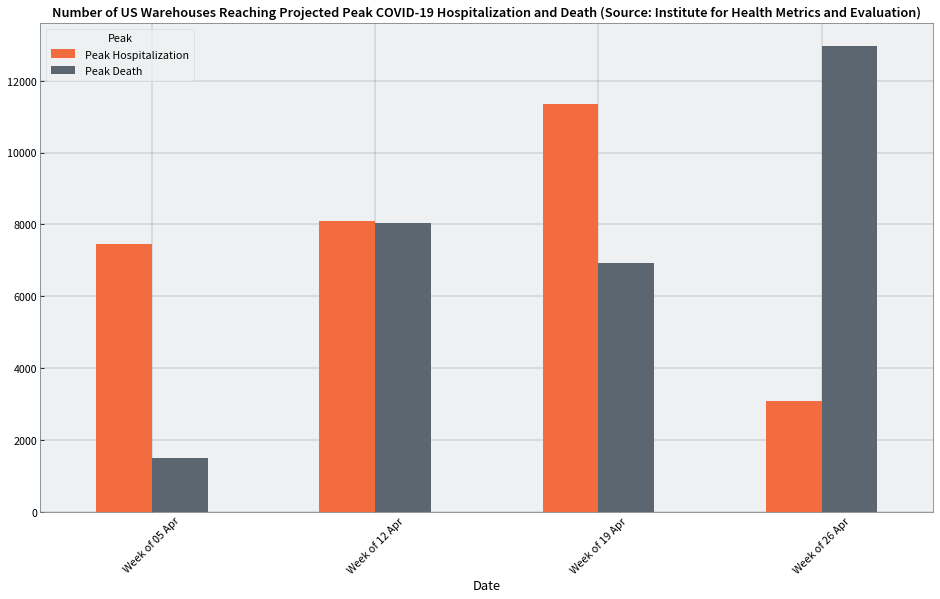

In [968]:
figsize(16, 9)
source = f[f['Date'] > '2020-03-29'].groupby(['Date', 'Peak'])['Warehouses'].sum().unstack('Peak').reindex(columns=['Peak Hospitalization', 'Peak Death'])

ax = source.plot(kind='bar',
                 color=['#f36c3f', '#5b6670'],
                 title="Number of US Warehouses Reaching Projected Peak COVID-19 Hospitalization and Death (Source: Institute for Health Metrics and Evaluation)")

ax.set_xticklabels(["Week of {0}".format(x.strftime("%d %b")) for x in source.index], rotation=45)

In [974]:
travel_change_by_county[travel_change_by_county['State'] == 'Georgia']['Warehouses'].sum()

1217

In [977]:
travel_change_by_county[travel_change_by_county['State'] == 'Georgia']['pct_change'].mean()

-0.5575849056603774

In [982]:
travel_change_by_county[travel_change_by_county['State'].isin(['Georgia', 'Pennsylvania', 'South Dakota'])].groupby('State')['Warehouses'].sum()

State
Georgia         1217
Pennsylvania    1221
South Dakota      16
Name: Warehouses, dtype: int64

In [979]:
travel_change_by_county[travel_change_by_county['State'].isin(['Georgia', 'Pennsylvania', 'South Dakota'])]['Warehouses'].sum()

2454

In [978]:
travel_change_by_county[travel_change_by_county['State'].isin(['Georgia', 'Pennsylvania', 'South Dakota'])]['pct_change'].mean()

-0.6330205479452055

In [983]:
travel_change_by_county[travel_change_by_county['State'] == 'Pennsylvania']['pct_change'].mean()

-0.7474776119402986

In [985]:
travel_change_by_county.groupby('State')['pct_change'].mean().sort_values()

State
District of Columbia   -0.981000
New Jersey             -0.901143
Michigan               -0.896795
Vermont                -0.869286
Colorado               -0.861562
Massachusetts          -0.847357
Washington             -0.829692
Ohio                   -0.823898
Indiana                -0.792826
Connecticut            -0.775125
Wisconsin              -0.772403
Illinois               -0.753873
Rhode Island           -0.750600
Idaho                  -0.749773
California             -0.749759
Pennsylvania           -0.747478
Maryland               -0.746208
West Virginia          -0.745182
Oregon                 -0.743222
New York               -0.741726
Maine                  -0.734500
Iowa                   -0.732495
Arizona                -0.720067
Delaware               -0.710667
New Hampshire          -0.706700
Minnesota              -0.702943
South Dakota           -0.698561
North Dakota           -0.692830
Nebraska               -0.690591
Kansas                 -0.680333
Miss

In [875]:
alt.Chart(f[f['Date'] > '2020-03-29']).mark_bar().encode(
    x='Date:O',
    y=alt.Y('Warehouses:Q', stack=False),
    color='Peak'
).properties(
    width=900,
    height=600
)

alt.Chart(...)

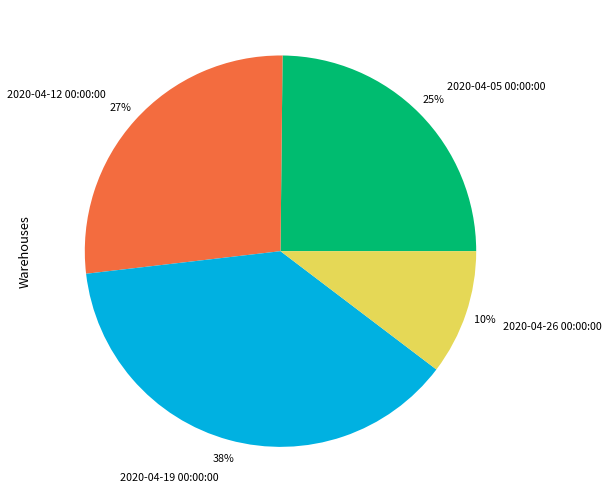

In [753]:
travel_change_by_county[travel_change_by_county['Peak Hospitalization Date'] >= '2020-03-29'].groupby('Peak Hospitalization Date')['Warehouses'].sum().resample('W').sum().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)

In [738]:
figsize(16, 9)
alt.Chart(travel_change_by_county[['label', 'Peak Hospitalization', 'Peak Hospitalization Date', 'Warehouses']]).mark_circle().encode(
    alt.Y('Peak Hospitalization:Q'),
    alt.X('Peak Hospitalization Date:T'),
    size='Warehouses:Q',
    tooltip=['label:N',
             'Warehouses:Q',
             'Peak Hospitalization:Q',
             'Peak Hospitalization Date:T']
).properties(
    width=900,
    height=600
)

alt.Chart(...)

In [740]:
travel_change_by_county['State Total COVID-19 Tests'] = travel_change_by_county['total']

In [917]:
figsize(16, 9)
alt.Chart(travel_change_by_county[['label', 'State Total COVID-19 Tests', 'Peak Hospitalization Date', 'Warehouses']]).mark_circle().encode(
    alt.Y('State Total COVID-19 Tests:Q'),
    alt.X('Peak Hospitalization Date:T'),
    size='Warehouses:Q',
    tooltip=['label:N',
             'Warehouses:Q',
             'State Total COVID-19 Tests:Q',
             'Peak Hospitalization Date:T']
).properties(
    width=900,
    height=600
)

alt.Chart(...)

In [ ]:
ax = 